https://github.com/ethanluoyc/pytorch-vae
https://github.com/pytorch/examples/tree/master/vae
https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

In [2]:
#get data

from data_utils import load_mnist

trX, teX, _, _ = load_mnist(onehot=False)

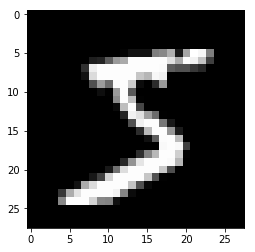

In [3]:
#view data

import matplotlib.pyplot as plt

plt.imshow(trX[0].reshape(28,28), cmap=plt.get_cmap('gray')) #need cmap thing or else is weird colour
plt.show()

In [4]:
#convert from numpy arrays to torch tensors

trX = torch.from_numpy(trX).float()
teX = torch.from_numpy(teX).float()

In [5]:
#create model

class Gaussian(nn.Module):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

In [7]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

In [8]:
class VAE(torch.nn.Module):
    latent_dim = 10

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 10)
        self._enc_log_sigma = torch.nn.Linear(100, 10)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)

In [9]:
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

In [10]:
#create instance of VAE class

hidden_dim = 100
z_dim = 10

encoder = Encoder(trX.shape[1], hidden_dim, hidden_dim)
decoder = Decoder(z_dim, hidden_dim, trX.shape[1])
vae = VAE(encoder, decoder)

In [11]:
#define some parameters

epochs = 10
batch_size = 32
learning_rate = 0.0001
momentum = 0.9

In [12]:
#for plotting

plot_loss = []
plot_correct = []

In [13]:
#define loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [14]:
#training function

def train(model, criterion, optimizer, x, y):
    x = Variable(x, requires_grad=False)
    y = Variable(y, requires_grad=False)
    
    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    
    #losses
    ll = latent_loss(vae.z_mean, vae.z_sigma)
    loss = criterion(fx, y) + ll

    # Backward
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data[0]

In [15]:
#run the training

num_examples = trX.shape[0]
num_batches = num_examples // batch_size

for e in range(1, epochs+1):
    loss = 0.
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size        
        loss += train(vae, criterion, optimizer, trX[start:end], trX[start:end])
    plot_loss.append(loss/num_batches)
    print("Epoch %02d, loss = %f" % (e, loss / num_batches))

Epoch 01, loss = 0.074810
Epoch 02, loss = 0.068936
Epoch 03, loss = 0.068151
Epoch 04, loss = 0.067825
Epoch 05, loss = 0.067665
Epoch 06, loss = 0.067577
Epoch 07, loss = 0.067519
Epoch 08, loss = 0.067489
Epoch 09, loss = 0.067462
Epoch 10, loss = 0.067444


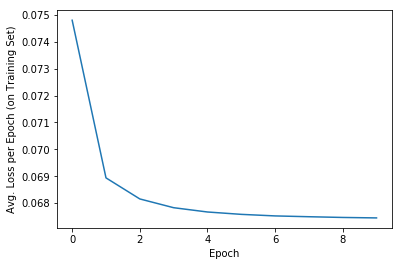

In [16]:
plt.plot(plot_loss)
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss per Epoch (on Training Set)')
plt.show()

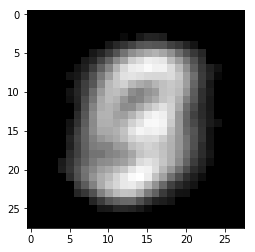

In [17]:
teX = Variable(teX, requires_grad=False)
plt.imshow(vae(teX).data[0].numpy().reshape(28, 28), cmap='gray')
plt.show()

In [18]:
print(teX)

Variable containing:
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.FloatTensor of size 10000x784]



In [19]:
fx = vae.forward(teX)

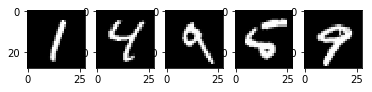

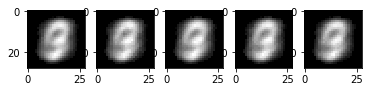

In [20]:
#view some

num_display = 5

fig = plt.figure()

for i in range(num_display):
    fig.add_subplot(1,num_display,i+1)
    plt.imshow(np.reshape(teX[i+5].data.numpy(), (28,28)), cmap=plt.get_cmap('gray'))
    
fig = plt.figure()

for i in range(num_display):
    fig.add_subplot(1,num_display,i+1)
    plt.imshow(np.reshape(fx[i+5].data.numpy(), (28,28)), cmap=plt.get_cmap('gray'))
    
plt.show()